In [54]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os


In [55]:
# Verzeichnis-Basis
base_path = "./Data/serverCircuitBreaker/L1"
base_path_L2 = "./Data/serverCircuitBreaker/L2"
base_path_L3 = "./Data/serverCircuitBreaker/L3"
# Pfads zu den CSV-Dateien L_1
df_L1_1 = pd.read_csv(f"{base_path}/15-09-28_results.jtl")
docker_df_L1_1 = pd.read_csv(f"{base_path}/15-09-28_docker_stats_live.csv")
df_L1_2 = pd.read_csv(f"{base_path}/15-10-00_results.jtl")
docker_df_L1_2 = pd.read_csv(f"{base_path}/15-10-00_docker_stats_live.csv")
df_L1_3 = pd.read_csv(f"{base_path}/15-12-20_results.jtl")
docker_df_L1_3 = pd.read_csv(f"{base_path}/15-12-20_docker_stats_live.csv")
# Pfads zu den CSV-Dateien L_2
df_L2_1 = pd.read_csv(f"{base_path_L2}/16-08-22_results.jtl")
docker_df_L2_1 = pd.read_csv(f"{base_path_L2}/16-08-22_docker_stats_live.csv")
df_L2_2 = pd.read_csv(f"{base_path_L2}/16-12-17_results.jtl")
docker_df_L2_2 = pd.read_csv(f"{base_path_L2}/16-12-17_docker_stats_live.csv")
df_L2_3 = pd.read_csv(f"{base_path_L2}/16-38-12_results.jtl")
docker_df_L2_3 = pd.read_csv(f"{base_path_L2}/16-38-12_docker_stats_live.csv")
# Pfads zu den CSV-Dateien L_3
df_L3_1 = pd.read_csv(f"{base_path_L3}/16-45-42_results.jtl", low_memory=False)
docker_df_L3_1 = pd.read_csv(f"{base_path_L3}/16-45-42_docker_stats_live.csv")
df_L3_2 = pd.read_csv(f"{base_path_L3}/17-09-29_results.jtl", low_memory=False)
docker_df_L3_2 = pd.read_csv(f"{base_path_L3}/17-09-29_docker_stats_live.csv")
df_L3_3 = pd.read_csv(f"{base_path_L3}/17-24-22_results.jtl", low_memory=False)
docker_df_L3_3 = pd.read_csv(f"{base_path_L3}/17-24-22_docker_stats_live.csv")       

In [56]:
df_L1_1.head()
df_L1_1.columns 

df_L1_2.head()
df_L1_2.columns 

df_L1_2.head()
df_L1_2.columns

df_L2_1.head()
df_L2_1.columns
df_L2_2.head()
df_L2_2.columns

df_L3_1.head()
df_L3_1.columns
df_L3_2.head()
df_L3_2.columns


Index(['timeStamp', 'elapsed', 'label', 'responseCode', 'responseMessage',
       'threadName', 'dataType', 'success', 'failureMessage', 'bytes',
       'sentBytes', 'grpThreads', 'allThreads', 'URL', 'Latency', 'IdleTime',
       'Connect'],
      dtype='object')

In [58]:
# Erfolgreiche Requests filtern
def extract_success(df):
    return df[df['success'].astype(str).str.lower() == "true"]

for label, df in [("L1", df_L1_1), ("L2", df_L2_1), ("L3", df_L3_1)]:
    print(f"{label}: success-Werte →", df["success"].astype(str).str.lower().value_counts())
# L1 – Geringe Last
df_L1_1_success = extract_success(df_L1_1)
df_L1_2_success = extract_success(df_L1_2)
df_L1_3_success = extract_success(df_L1_3)
df_L1_success_combined = pd.concat([df_L1_1_success, df_L1_2_success, df_L1_3_success], ignore_index=True)

# L2 – Mittlere Last
df_L2_1_success = extract_success(df_L2_1)
df_L2_2_success = extract_success(df_L2_2)
df_L2_3_success = extract_success(df_L2_3)
df_L2_success_combined = pd.concat([df_L2_1_success, df_L2_2_success, df_L2_3_success], ignore_index=True)

# L3 – Hohe Last
df_L3_1_success = extract_success(df_L3_1)
df_L3_2_success = extract_success(df_L3_2)
df_L3_3_success = extract_success(df_L3_3)
df_L3_success_combined = pd.concat([df_L3_1_success, df_L3_2_success, df_L3_3_success], ignore_index=True)

# Metriken berechnen
def extract_metrics(df, label):
    return {
        "Laststufe": label,
        "Mittelwert": df["elapsed"].mean(),
        "95. Perzentil": df["elapsed"].quantile(0.95),
        "Maximum": df["elapsed"].max()
    }

# Reaktionszeit-Metriken zusammenfassen
reaction_df = pd.DataFrame([
    extract_metrics(df_L1_success_combined, "L1 – Geringe Last"),
    extract_metrics(df_L2_success_combined, "L2 – Mittlere Last"),
    extract_metrics(df_L3_success_combined, "L3 – Hohe Last")
])

# Ausgabe zur Kontrolle
reaction_df


L1: success-Werte → success
true    1000
Name: count, dtype: int64
L2: success-Werte → success
false    6560
true     3440
Name: count, dtype: int64
L3: success-Werte → success
false    75000
Name: count, dtype: int64


,Laststufe,Mittelwert,95. Perzentil,Maximum
0,L1 – Geringe Last,45.957333,5.0,32456.0
1,L2 – Mittlere Last,2711.223271,362.5,65166.0
2,L3 – Hohe Last,NaN,NaN,NaN


In [117]:
# Konvertierungsfunktionen
def convert_to_mib(x):
    if "MiB" in x: return float(x.replace("MiB", "").strip())
    if "GiB" in x: return float(x.replace("GiB", "").strip()) * 1024
    if "KiB" in x: return float(x.replace("KiB", "").strip()) / 1024
    return 0.0

def convert_to_mb(x):
    if "MB" in x: return float(x.replace("MB", "").strip())
    if "kB" in x: return float(x.replace("kB", "").strip()) / 1024
    if "B" in x: return float(x.replace("B", "").strip()) / (1024 * 1024)
    return 0.0

# Parserfunktion für CSVs mit TEST_START / TEST_END
def parse_docker_stats_within_markers(csv_path):
    with open(csv_path, 'r') as file:
        lines = file.readlines()
    start_idx = next(i for i, line in enumerate(lines) if "TEST_START" in line)
    end_idx = next(i for i, line in enumerate(lines) if "TEST_END" in line)
    content = lines[start_idx+1:end_idx]
    df = pd.DataFrame([line.strip().split(',') for line in content], columns=["Container", "CPU", "RAM", "NetIO"])
    relevant = ["myservice", "backend-a-1"]
    df = df[df["Container"].isin(relevant)].copy()
    df[["RAM_Used", "RAM_Total"]] = df["RAM"].str.split(" / ", expand=True)
    df[["Net_In", "Net_Out"]] = df["NetIO"].str.split(" / ", expand=True)
    df["CPU_%"] = df["CPU"].str.replace("%", "").astype(float)
    df["RAM_Used_MiB"] = df["RAM_Used"].apply(convert_to_mib)
    df["Net_In_MB"] = df["Net_In"].apply(convert_to_mb)
    df["Net_Out_MB"] = df["Net_Out"].apply(convert_to_mb)
    return df
# 📥 Einlesen aller Docker-Dateien (nur TEST_START–TEST_END) über Parserfunktion

# L1
docker_df_L1_1 = parse_docker_stats_within_markers("./Data/serverCircuitBreaker/L1/15-09-28_docker_stats_live.csv")
docker_df_L1_2 = parse_docker_stats_within_markers("./Data/serverCircuitBreaker/L1/15-10-00_docker_stats_live.csv")
docker_df_L1_3 = parse_docker_stats_within_markers("./Data/serverCircuitBreaker/L1/15-12-20_docker_stats_live.csv")

# L2
docker_df_L2_1 = parse_docker_stats_within_markers("./Data/serverCircuitBreaker/L2/16-08-22_docker_stats_live.csv")
docker_df_L2_2 = parse_docker_stats_within_markers("./Data/serverCircuitBreaker/L2/16-12-17_docker_stats_live.csv")
docker_df_L2_3 = parse_docker_stats_within_markers("./Data/serverCircuitBreaker/L2/16-38-12_docker_stats_live.csv")

# L3
docker_df_L3_1 = parse_docker_stats_within_markers("./Data/serverCircuitBreaker/L3//16-45-42_docker_stats_live.csv")
docker_df_L3_2 = parse_docker_stats_within_markers("./Data/serverCircuitBreaker/L3/17-09-29_docker_stats_live.csv")
docker_df_L3_3 = parse_docker_stats_within_markers("./Data/serverCircuitBreaker/L3/17-24-22_docker_stats_live.csv")


# Kombination der Datensätze
docker_df_L1_combined = pd.concat([docker_df_L1_1, docker_df_L1_2, docker_df_L1_3], ignore_index=True)
docker_df_L2_combined = pd.concat([docker_df_L2_1, docker_df_L2_2, docker_df_L2_3], ignore_index=True)
docker_df_L3_combined = pd.concat([docker_df_L3_1, docker_df_L3_2, docker_df_L3_3], ignore_index=True)  # falls vorhanden

# Relevante Container extrahieren
relevant = ["myservice", "backend-a-1"]
docker_df_L1_relevant = docker_df_L1_combined[docker_df_L1_combined["Container"].isin(relevant)].copy()
docker_df_L2_relevant = docker_df_L2_combined[docker_df_L2_combined["Container"].isin(relevant)].copy()
docker_df_L3_relevant = docker_df_L3_combined[docker_df_L3_combined["Container"].isin(relevant)].copy()


# Metrik-Funktion
def extract_resource_metrics(df, label):
    grouped = df.groupby("Container")
    result = []
    for container, group in grouped:
        result.append({
            "Laststufe": label,
            "Container": container,
            "RAM_avg_MB": group["RAM_Used_MiB"].mean() * 1.048576,
            "RAM_max_MB": group["RAM_Used_MiB"].max() * 1.048576,
            "CPU_avg_%": group["CPU_%"].mean(),
            "CPU_max_%": group["CPU_%"].max(),
            "Net_In_MB": group["Net_In_MB"].mean(),
            "Net_Out_MB": group["Net_Out_MB"].mean()
        })
    return pd.DataFrame(result)

# Metriken extrahieren pro Laststufe
resource_df_L1 = extract_resource_metrics(docker_df_L1_relevant, "L1 – Geringe Last")
resource_df_L2 = extract_resource_metrics(docker_df_L2_relevant, "L2 – Mittlere Last")
resource_df_L3 = extract_resource_metrics(docker_df_L3_relevant, "L3 – Hohe Last")

# Zusammenführen aller Ergebnisse
resource_df_all = pd.concat([resource_df_L1, resource_df_L2, resource_df_L3], ignore_index=True)  

# Ausgabe zur Kontrolle
resource_df_all

,Laststufe,Container,RAM_avg_MB,RAM_max_MB,CPU_avg_%,CPU_max_%,Net_In_MB,Net_Out_MB
0,L1 – Geringe Last,backend-a-1,308.071629,325.373133,7.315455,38.22,0.748598,0.871868
1,L1 – Geringe Last,myservice,602.874005,604.818637,0.987727,8.98,0.011602,0.183487
2,L2 – Mittlere Last,backend-a-1,617.019802,740.399514,3.227083,370.08,7.502247,8.349481
3,L2 – Mittlere Last,myservice,580.689920,623.588147,0.550000,19.05,0.108860,2.063800
4,L3 – Hohe Last,backend-a-1,730.430375,783.286272,3.172583,638.93,51.161123,55.858893
5,L3 – Hohe Last,myservice,673.885791,681.259827,0.512288,20.95,0.240480,4.608374


In [105]:
import pandas as pd

# --- Hilfsfunktion: Zeit normalisieren ---
def normalize_and_sort(df):
    df = df.copy()
    df["time"] = pd.to_datetime(df["timeStamp"], unit="ms")
    df["t_norm"] = (df["time"] - df["time"].min()).dt.total_seconds()
    df = df.sort_values("t_norm")
    return df

# --- Daten vorbereiten (nur erfolgreiche Anfragen) ---
df_L1_success = df_L1_1[df_L1_1["responseCode"] == 200]
df_L2_success = df_L2_1[df_L2_1["responseCode"] == 200]
df_L3_success = df_L3_1[df_L3_1["responseCode"] == 200]

df_L1_norm = normalize_and_sort(df_L1_success)
df_L2_norm = normalize_and_sort(df_L2_success)
df_L3_norm = normalize_and_sort(df_L3_success)

# --- Gleitendes Mittel über 20 Anfragen ---
df_L1_norm["rolling"] = df_L1_norm["elapsed"].rolling(window=20).mean()
df_L2_norm["rolling"] = df_L2_norm["elapsed"].rolling(window=20).mean()
df_L3_norm["rolling"] = df_L3_norm["elapsed"].rolling(window=20).mean()

# --- Reaktionszeitmetriken extrahieren ---
def extract_metrics(df, label):
    return {
        "Laststufe": label,
        "Mittelwert": df["elapsed"].mean(),
        "95. Perzentil": df["elapsed"].quantile(0.95),
        "Maximum": df["elapsed"].max()
    }

reaction_df = pd.DataFrame([
    extract_metrics(df_L1_norm, "L1 – Geringe Last"),
    extract_metrics(df_L2_norm, "L2 – Mittlere Last"),
    extract_metrics(df_L3_norm, "L3 – Hohe Last")
])

# --- Umwandlung für Visualisierung ---
reaction_melted = reaction_df.melt(id_vars="Laststufe", var_name="Metrik", value_name="Reaktionszeit [ms]")


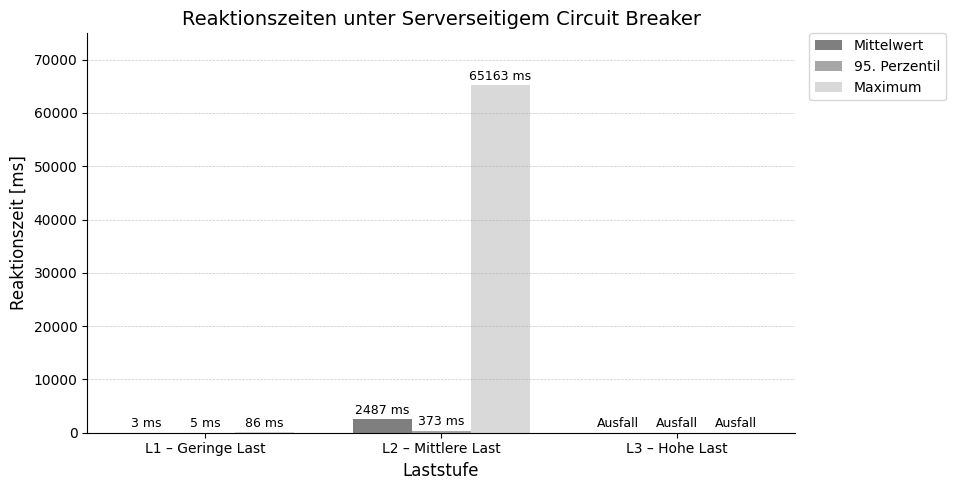

In [106]:
import matplotlib.pyplot as plt
import numpy as np

# --- Balkendiagramm nach Custom-Stil mit Beschriftung & Ausfallmarkierung ---

# Achsenlabels & Reihenfolge vorbereiten
labels_x = reaction_melted["Laststufe"].unique()
data_x = np.arange(len(labels_x))
width = 0.25

# Daten extrahieren
mittelwert = reaction_melted[reaction_melted["Metrik"] == "Mittelwert"]["Reaktionszeit [ms]"].values
perzentil = reaction_melted[reaction_melted["Metrik"] == "95. Perzentil"]["Reaktionszeit [ms]"].values
maximum = reaction_melted[reaction_melted["Metrik"] == "Maximum"]["Reaktionszeit [ms]"].values

# Plot
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot()

# Balken zeichnen
bars_mean = ax.bar(data_x - width, mittelwert, width, label="Mittelwert", color='#7f7f7f')
bars_pctl = ax.bar(data_x, perzentil, width, label="95. Perzentil", color='#a6a6a6')
bars_max = ax.bar(data_x + width, maximum, width, label="Maximum", color='#d9d9d9')

# Beschriftung der Balken (inkl. NaN als "Ausfall")
def annotate_bars(bars, werte, unit="ms", offset=500):
    for i, bar in enumerate(bars):
        height = bar.get_height()
        label = f"{int(height)} {unit}" if not np.isnan(height) else "Ausfall"
        ax.text(bar.get_x() + bar.get_width() / 2, height + offset if not np.isnan(height) else offset,
                label, ha='center', va='bottom', fontsize=9, rotation=0)

annotate_bars(bars_mean, mittelwert)
annotate_bars(bars_pctl, perzentil)
annotate_bars(bars_max, maximum)

# Achsenbeschriftung und Titel
ax.set_xlabel("Laststufe", fontsize=12)
ax.set_ylabel("Reaktionszeit [ms]", fontsize=12)
ax.set_title("Reaktionszeiten unter Serverseitigem Circuit Breaker", fontsize=14)

# X-Achse formatieren
ax.set_xticks(data_x)
ax.set_xticklabels(labels_x)
ax.tick_params(axis='both', labelsize=10)

# Gitterlinien
ax.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.7)

# Rahmen entfernen
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

# Legende
ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0)
ax.set_xlim(-0.5, len(labels_x) - 0.5)
ax.set_ylim(0, max(maximum[~np.isnan(maximum)]) * 1.15)

# Layout
plt.tight_layout()
plt.subplots_adjust(right=0.8)

plt.show()


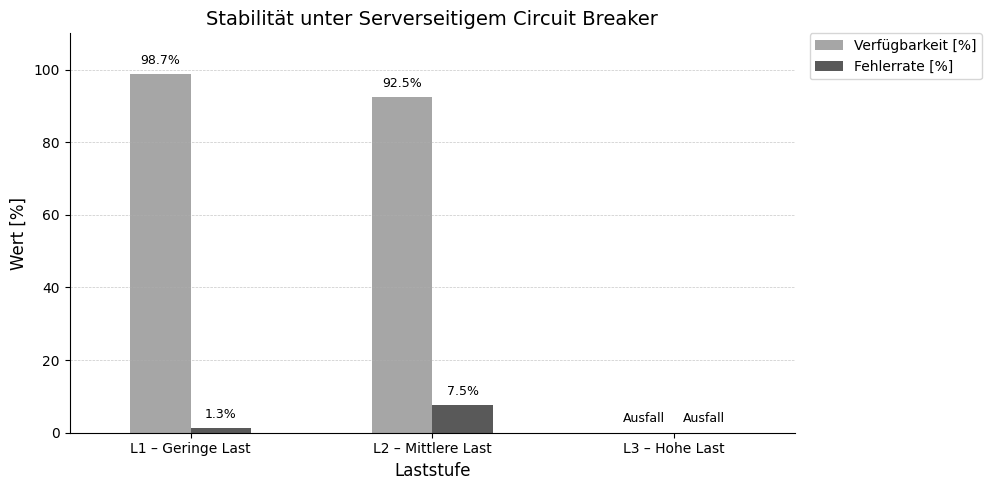

In [107]:
import matplotlib.pyplot as plt
import numpy as np

# --- Stabilitätsdaten vorbereiten ---
stability_df = pd.DataFrame([
    {"Laststufe": "L1 – Geringe Last", "Verfügbarkeit [%]": 98.7, "Fehlerrate [%]": 1.3},
    {"Laststufe": "L2 – Mittlere Last", "Verfügbarkeit [%]": 92.5, "Fehlerrate [%]": 7.5},
    {"Laststufe": "L3 – Hohe Last", "Verfügbarkeit [%]": np.nan, "Fehlerrate [%]": np.nan}
])

# Daten vorbereiten
labels_x = stability_df["Laststufe"].unique()
data_x = np.arange(len(labels_x))
width = 0.25

verf = stability_df["Verfügbarkeit [%]"].values
fehler = stability_df["Fehlerrate [%]"].values

# Plot
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot()

bars_verf = ax.bar(data_x - width / 2, verf, width, label="Verfügbarkeit [%]", color="#a6a6a6")
bars_fail = ax.bar(data_x + width / 2, fehler, width, label="Fehlerrate [%]", color="#595959")

# Beschriftung der Balken (auch bei NaN → "Ausfall")
def annotate_bars(bars, werte, unit="%", offset=2):
    for i, bar in enumerate(bars):
        height = bar.get_height()
        label = f"{height:.1f}{unit}" if not np.isnan(height) else "Ausfall"
        ax.text(bar.get_x() + bar.get_width() / 2, height + offset if not np.isnan(height) else offset,
                label, ha='center', va='bottom', fontsize=9)

annotate_bars(bars_verf, verf)
annotate_bars(bars_fail, fehler)

# Achsenbeschriftung und Titel
ax.set_xlabel("Laststufe", fontsize=12)
ax.set_ylabel("Wert [%]", fontsize=12)
ax.set_title("Stabilität unter Serverseitigem Circuit Breaker", fontsize=14)

# Achsenformatierung
ax.set_xticks(data_x)
ax.set_xticklabels(labels_x)
ax.tick_params(axis='both', labelsize=10)

# Gitter und Achsenrahmen
ax.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.7)
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

# Legende
ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0)

# Achsenbereiche anpassen
ax.set_ylim(0, 110)
ax.set_xlim(-0.5, len(labels_x) - 0.5)

# Layout
plt.tight_layout()
plt.subplots_adjust(right=0.8)
plt.show()


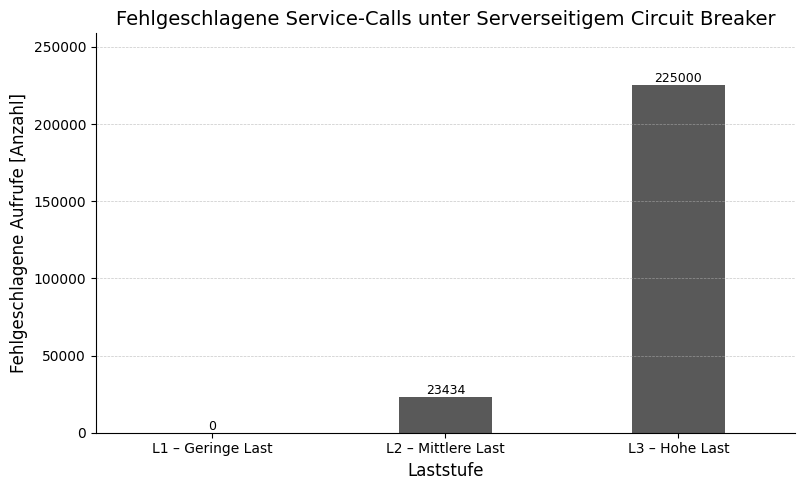

In [108]:
import matplotlib.pyplot as plt
import numpy as np

# --- Fehlversuche berechnen ---
fehlversuche_L1 = len(df_L1_1[df_L1_1["success"] == False]) + \
                  len(df_L1_2[df_L1_2["success"] == False]) + \
                  len(df_L1_3[df_L1_3["success"] == False])

fehlversuche_L2 = len(df_L2_1[df_L2_1["success"] == False]) + \
                  len(df_L2_2[df_L2_2["success"] == False]) + \
                  len(df_L2_3[df_L2_3["success"] == False])

fehlversuche_L3 = len(df_L3_1[df_L3_1["success"] == False]) + \
                  len(df_L3_2[df_L3_2["success"] == False]) + \
                  len(df_L3_3[df_L3_3["success"] == False])

# --- Balkendiagramm vorbereiten ---
labels_x = ["L1 – Geringe Last", "L2 – Mittlere Last", "L3 – Hohe Last"]
data_x = np.arange(len(labels_x))
anzahl = [fehlversuche_L1, fehlversuche_L2, fehlversuche_L3]
width = 0.4

# Plot
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot()

bars = ax.bar(data_x, anzahl, width=width, color="#595959")

# Balkenbeschriftung (inkl. 0 als "Ausfall")
for i, bar in enumerate(bars):
    height = bar.get_height()
    label = f"{int(height)}" 
    ax.text(bar.get_x() + bar.get_width() / 2, height + 30 if height > 0 else 30,
            label, ha='center', va='bottom', fontsize=9)

# Achsentitel & Diagrammtitel
ax.set_xlabel("Laststufe", fontsize=12)
ax.set_ylabel("Fehlgeschlagene Aufrufe [Anzahl]", fontsize=12)
ax.set_title("Fehlgeschlagene Service-Calls unter Serverseitigem Circuit Breaker", fontsize=14)

# Achsen-Formatierung
ax.set_xticks(data_x)
ax.set_xticklabels(labels_x)
ax.tick_params(axis='both', labelsize=10)

# Gitter und Layout
ax.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.7)
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

ax.set_ylim(0, max(anzahl) * 1.15 if max(anzahl) > 0 else 100)
ax.set_xlim(-0.5, len(labels_x) - 0.5)

plt.tight_layout()
plt.subplots_adjust(right=0.8)
plt.show()


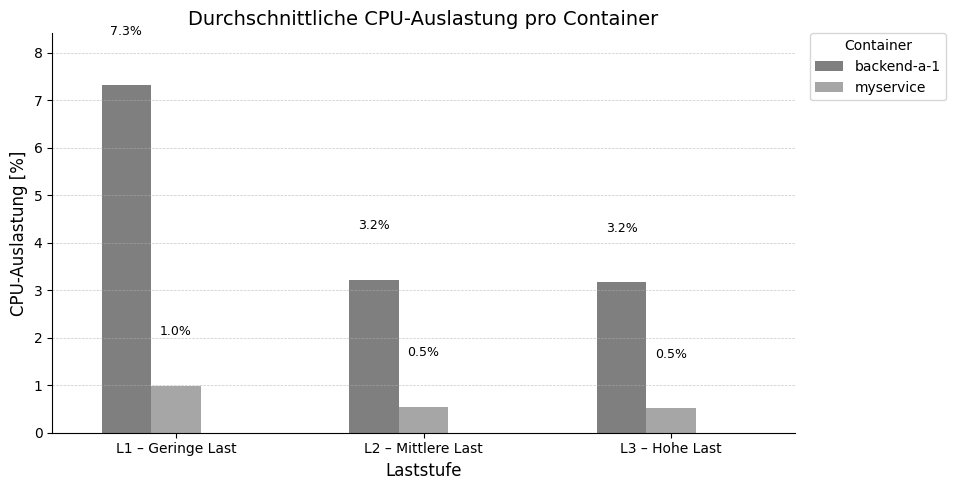

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# --- CPU-Metriken vorbereiten ---
docker_df_L1_combined["Laststufe"] = "L1 – Geringe Last"
docker_df_L2_combined["Laststufe"] = "L2 – Mittlere Last"
docker_df_L3_combined["Laststufe"] = "L3 – Hohe Last"
df_all = pd.concat([docker_df_L1_combined, docker_df_L2_combined, docker_df_L3_combined])

cpu = df_all.groupby(["Laststufe", "Container"])["CPU_%"].mean().reset_index()

# --- Achsenlabels vorbereiten ---
laststufen = cpu["Laststufe"].unique()
container = cpu["Container"].unique()
data_x = np.arange(len(laststufen))
width = 0.2

# --- Farben pro Container ---
farben = ['#7f7f7f', '#a6a6a6']

# --- Plot vorbereiten ---
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot()

# --- Balken zeichnen ---
for i, name in enumerate(container):
    werte = cpu[cpu["Container"] == name]["CPU_%"].values
    bars = ax.bar(data_x + (i - 1) * width, werte, width=width, label=name, color=farben[i])

    # Balkenbeschriftung
    for j, bar in enumerate(bars):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 2, height + 1, f"{height:.1f}%", ha='center', va='bottom', fontsize=9)

# --- Achsentitel und Diagrammtitel ---
ax.set_xlabel("Laststufe", fontsize=12)
ax.set_ylabel("CPU-Auslastung [%]", fontsize=12)
ax.set_title("Durchschnittliche CPU-Auslastung pro Container", fontsize=14)

# --- X-Achse formatieren ---
ax.set_xticks(data_x)
ax.set_xticklabels(laststufen)
ax.tick_params(axis='both', labelsize=10)

# --- Gitterlinien & Rahmen ---
ax.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.7)
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

# --- Achsenbereich ---
ax.set_ylim(0, cpu["CPU_%"].max() * 1.15)
ax.set_xlim(-0.5, len(laststufen) - 0.5)

# --- Legende ---
ax.legend(title="Container", loc='upper left', bbox_to_anchor=(1.02, 1), borderaxespad=0)

# --- Layout ---
plt.tight_layout()
plt.subplots_adjust(right=0.8)
plt.show()


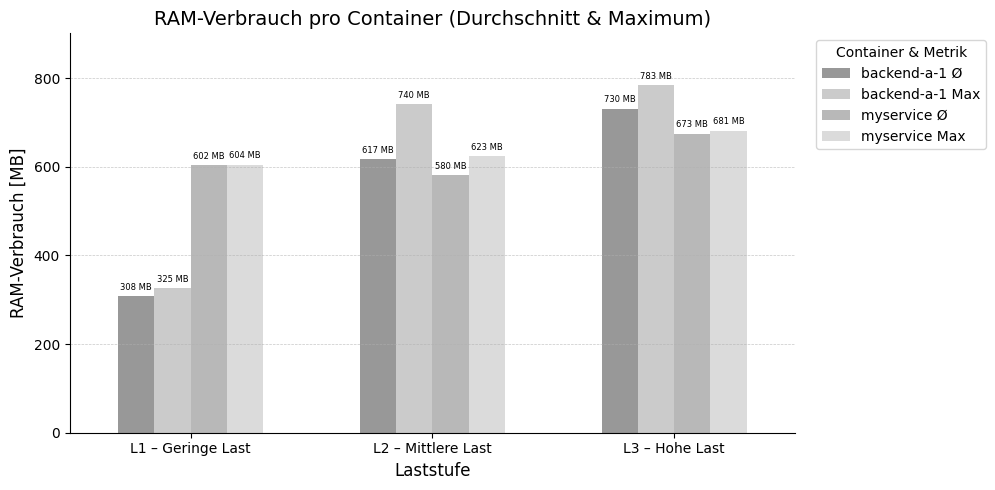

In [119]:
import matplotlib.pyplot as plt
import numpy as np

# --- RAM Balkenplot (MB) mit optimiertem Abstand & Beschriftung ---
ram_avg = resource_df_all.pivot(index="Laststufe", columns="Container", values="RAM_avg_MB")
ram_max = resource_df_all.pivot(index="Laststufe", columns="Container", values="RAM_max_MB")

laststufen = ram_avg.index.tolist()
container = ram_avg.columns.tolist()
data_x = np.arange(len(laststufen))

# Breiten
group_width = 0.6
bar_width = group_width / (len(container) * 2)

# Farben
farben = ['#7f7f7f', '#a6a6a6']

# Plot
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot()

for i, cont in enumerate(container):
    # Balkenpositionen
    avg_pos = data_x + (i - 0.5) * group_width / len(container) - bar_width / 2
    max_pos = avg_pos + bar_width

    # Daten
    avg_vals = ram_avg[cont].values
    max_vals = ram_max[cont].values

    # Balken zeichnen
    bars_avg = ax.bar(avg_pos, avg_vals, width=bar_width, label=f"{cont} Ø", color=farben[i], alpha=0.8)
    bars_max = ax.bar(max_pos, max_vals, width=bar_width, label=f"{cont} Max", color=farben[i], alpha=0.4)

    # Beschriftung
    for bar in bars_avg:
        h = bar.get_height()
        if not np.isnan(h):
            ax.text(bar.get_x() + bar.get_width() / 2, h + 10, f"{int(h)} MB", ha='center', va='bottom', fontsize=6)
    for bar in bars_max:
        h = bar.get_height()
        if not np.isnan(h):
            ax.text(bar.get_x() + bar.get_width() / 2, h + 10, f"{int(h)} MB", ha='center', va='bottom', fontsize=6)

# Achsenbeschriftung & Formatierung
ax.set_xlabel("Laststufe", fontsize=12)
ax.set_ylabel("RAM-Verbrauch [MB]", fontsize=12)
ax.set_title("RAM-Verbrauch pro Container (Durchschnitt & Maximum)", fontsize=14)

ax.set_xticks(data_x)
ax.set_xticklabels(laststufen)
ax.tick_params(axis='both', labelsize=10)
ax.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.7)

for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

ax.set_ylim(0, np.nanmax(ram_max.values) * 1.15)
ax.set_xlim(-0.5, len(laststufen) - 0.5)

ax.legend(title="Container & Metrik", loc='upper left', bbox_to_anchor=(1.02, 1))

plt.tight_layout()
plt.subplots_adjust(right=0.8)
plt.show()


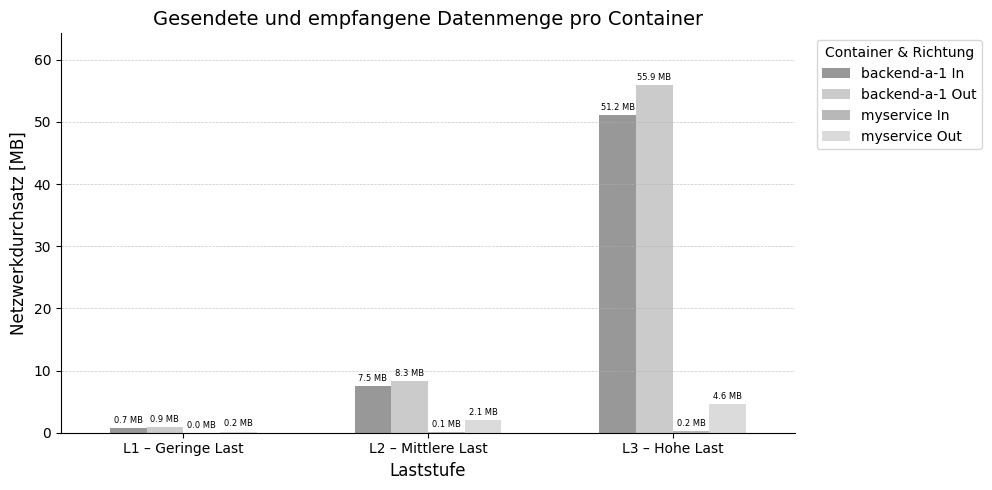

In [121]:
import matplotlib.pyplot as plt
import numpy as np

# --- NetIO-Daten vorbereiten ---
net_in = resource_df_all.pivot(index="Laststufe", columns="Container", values="Net_In_MB")
net_out = resource_df_all.pivot(index="Laststufe", columns="Container", values="Net_Out_MB")

laststufen = net_in.index.tolist()
container = net_in.columns.tolist()
data_x = np.arange(len(laststufen))

# Breiten
group_width = 0.6
bar_width = group_width / (len(container) * 2)

# Farben
farben = ['#7f7f7f', '#a6a6a6']

# Plot
fig = plt.figure(figsize=(10, 5))
ax = fig.add_subplot()

for i, cont in enumerate(container):
    # Balkenpositionen
    in_pos = data_x + (i - 0.5) * group_width / len(container) - bar_width / 2
    out_pos = in_pos + bar_width

    # Werte
    in_vals = net_in[cont].values
    out_vals = net_out[cont].values

    # Balken zeichnen
    bars_in = ax.bar(in_pos, in_vals, width=bar_width, label=f"{cont} In", color=farben[i], alpha=0.8)
    bars_out = ax.bar(out_pos, out_vals, width=bar_width, label=f"{cont} Out", color=farben[i], alpha=0.4)

    # Beschriftung beider Balken
    for bar in bars_in:
        h = bar.get_height()
        if not np.isnan(h):
            ax.text(bar.get_x() + bar.get_width() / 2, h + 0.5, f"{h:.1f} MB", ha='center', va='bottom', fontsize=6)
    for bar in bars_out:
        h = bar.get_height()
        if not np.isnan(h):
            ax.text(bar.get_x() + bar.get_width() / 2, h + 0.5, f"{h:.1f} MB", ha='center', va='bottom', fontsize=6)

# Achsen & Titel
ax.set_xlabel("Laststufe", fontsize=12)
ax.set_ylabel("Netzwerkdurchsatz [MB]", fontsize=12)
ax.set_title("Gesendete und empfangene Datenmenge pro Container", fontsize=14)

# X-Achse
ax.set_xticks(data_x)
ax.set_xticklabels(laststufen)
ax.tick_params(axis='both', labelsize=10)

# Gitter
ax.grid(axis='y', linestyle='--', linewidth=0.5, alpha=0.7)

# Rahmen
for spine in ['top', 'right']:
    ax.spines[spine].set_visible(False)

# Achsenbereich
y_max = np.nanmax([net_in.values.max(), net_out.values.max()]) * 1.15
ax.set_ylim(0, y_max)
ax.set_xlim(-0.5, len(laststufen) - 0.5)

# Legende
ax.legend(title="Container & Richtung", loc='upper left', bbox_to_anchor=(1.02, 1))

# Layout
plt.tight_layout()
plt.subplots_adjust(right=0.8)
plt.show()
